# **Who cut my card?**
### Given personal, banking history and credit card transactions, which customers are likely to cancel their credit card?

<br>

## Approach
1. Data is in the form of 3 different datasets. I want to submit only one dataset to the model so I will merge the 3 datasets into one.
2. For each data set, examine the features - what feature should be categorical, what features can we engineer from existing data?
3. Examine the data as a whole, what does our data look like, do we have any outliers, is our data skewed, what features will be good predictors?

<br>
IMPORTS


In [384]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

import seaborn as sns
SEED = 14

#### Create folder structure

In [385]:
import os
for d in ['orig\data', 'output']:
    os.makedirs(d, exist_ok=True)

#### Import accounts.csv data to dataframe

In [386]:
df_accounts = pd.read_csv("orig/accounts_train.csv")
print(df_accounts.shape)
df_accounts.head(10)

(25012, 2)


,Customer,Account
0,828247016,Investment
1,828247016,Current
2,828247016,Credit Card
3,828247016,On Demand Deposit
4,828247016,Mortgage
5,828247016,Joint
6,794487117,On Demand Deposit
7,794487117,Mortgage
8,794487117,Current
9,794487117,Credit Card


<br>

### First of all, make each account a binary feature as each account customer relates to multiple accounts. This will give us one observation per customer


In [387]:
cols = df_accounts.Account.unique()


In [388]:
df_accounts2 = pd.DataFrame(columns ={'Investment', 'Current', 'Credit_Card', 'On_Demand_Deposit','Mortgage', 'Joint', 'Deposit', 'Loan'})
df_accounts2

,Credit_Card,Current,Deposit,Mortgage,Loan,On_Demand_Deposit,Joint,Investment


In [389]:
frames = [df_accounts,df_accounts2]
df_accounts3 = pd.concat(frames)
df_accounts3

,Customer,Account,Credit_Card,Current,Deposit,Mortgage,Loan,On_Demand_Deposit,Joint,Investment
0,828247016.0,Investment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,828247016.0,Current,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,828247016.0,Credit Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,828247016.0,On Demand Deposit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,828247016.0,Mortgage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
25007,812694049.0,Deposit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25008,812694049.0,Mortgage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25009,812694049.0,Credit Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25010,812694049.0,Investment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [390]:
df_accounts3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25012 entries, 0 to 25011
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Customer           25012 non-null  float64
 1   Account            25012 non-null  object 
 2   Credit_Card        0 non-null      object 
 3   Current            0 non-null      object 
 4   Deposit            0 non-null      object 
 5   Mortgage           0 non-null      object 
 6   Loan               0 non-null      object 
 7   On_Demand_Deposit  0 non-null      object 
 8   Joint              0 non-null      object 
 9   Investment         0 non-null      object 
dtypes: float64(1), object(9)
memory usage: 2.1+ MB


<br>

#### If the customer has the account type set the value to 1, otherwise, set to 0

Supress warnings (makes it easier to read the notebook!)

In [391]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [392]:
df_accounts3['On_Demand_Deposit'].loc[df_accounts3['Account']=='On Demand Deposit'] = 1
df_accounts3['Credit_Card'].loc[df_accounts3['Account']=='Credit Card'] = 1
df_accounts3['Loan'].loc[df_accounts3['Account']=='Loan'] = 1
df_accounts3['Joint'].loc[df_accounts3['Account']=='Joint'] = 1
df_accounts3['Deposit'].loc[df_accounts3['Account']=='Deposit'] = 1
df_accounts3['Mortgage'].loc[df_accounts3['Account']=='Mortgage'] = 1
df_accounts3['Current'].loc[df_accounts3['Account']=='Current'] = 1
df_accounts3['Investment'].loc[df_accounts3['Account']=='Investment'] = 1



df_accounts3=df_accounts3.fillna(0)

In [393]:
df_accounts3 = df_accounts3.drop_duplicates()

#### Add a feature that will say how many accounts a customer has - num_accs

In [394]:
df_accounts3_count = df_accounts3.groupby(['Customer']).count().reset_index()
df_accounts3_count = df_accounts3_count.rename(columns ={"Account": "num_accs"})
df_accounts4_count= df_accounts3_count[["Customer", "num_accs"]]
df_accounts4_count

,Customer,num_accs
0,708115009.0,1
1,708117651.0,2
2,708163600.0,3
3,708166361.0,4
4,708169780.0,2
...,...,...
6572,828277434.0,3
6573,828283866.0,3
6574,828288658.0,6
6575,828290781.0,2


Merge the num_accs to the accounts dataframe

In [395]:
df_accounts4 = (pd.merge(df_accounts4_count, df_accounts3, on='Customer'))
df_accounts4

,Customer,num_accs,Account,Credit_Card,Current,Deposit,Mortgage,Loan,On_Demand_Deposit,Joint,Investment
0,708115009.0,1,Credit Card,1,0,0,0,0,0,0,0
1,708117651.0,2,Current,0,1,0,0,0,0,0,0
2,708117651.0,2,Credit Card,1,0,0,0,0,0,0,0
3,708163600.0,3,On Demand Deposit,0,0,0,0,0,1,0,0
4,708163600.0,3,Credit Card,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
24859,828288658.0,6,On Demand Deposit,0,0,0,0,0,1,0,0
24860,828288658.0,6,Mortgage,0,0,0,1,0,0,0,0
24861,828290781.0,2,Credit Card,1,0,0,0,0,0,0,0
24862,828290781.0,2,Current,0,1,0,0,0,0,0,0


#### Drop the Account column as it is no longer required (it is now a set of binary features)

In [396]:
df_accounts4 = df_accounts4.drop(columns='Account')


In [397]:
df_accounts4 =df_accounts4.groupby(['Customer']).sum().reset_index()

In [398]:
df_accounts4

,Customer,num_accs,Credit_Card,Current,Deposit,Mortgage,Loan,On_Demand_Deposit,Joint,Investment
0,708115009.0,1,1,0,0,0,0,0,0,0
1,708117651.0,4,1,1,0,0,0,0,0,0
2,708163600.0,9,1,1,0,0,0,1,0,0
3,708166361.0,16,1,1,1,1,0,0,0,0
4,708169780.0,4,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
6572,828277434.0,9,1,1,1,0,0,0,0,0
6573,828283866.0,9,1,0,1,0,0,1,0,0
6574,828288658.0,36,1,1,0,1,1,1,0,1
6575,828290781.0,4,1,1,0,0,0,0,0,0


In [399]:
df_accounts4.Customer.astype(int)

0       708115009
1       708117651
2       708163600
3       708166361
4       708169780
          ...    
6572    828277434
6573    828283866
6574    828288658
6575    828290781
6576    828317722
Name: Customer, Length: 6577, dtype: int32

In [400]:
df_accounts4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6577 entries, 0 to 6576
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Customer           6577 non-null   float64
 1   num_accs           6577 non-null   int64  
 2   Credit_Card        6577 non-null   int64  
 3   Current            6577 non-null   int64  
 4   Deposit            6577 non-null   int64  
 5   Mortgage           6577 non-null   int64  
 6   Loan               6577 non-null   int64  
 7   On_Demand_Deposit  6577 non-null   int64  
 8   Joint              6577 non-null   int64  
 9   Investment         6577 non-null   int64  
dtypes: float64(1), int64(9)
memory usage: 514.0 KB


#### Import the customer.csv data into a data frame

In [401]:
df_customers = pd.read_csv("orig/customers_train.csv")
print(df_customers.shape)
df_customers.head(10)

(6577, 15)


,Customer,Churn,Card,Start_Date,Customer_Service_Calls,Credit_Limit,Total_Revolving_Balance,Average_Open_To_Buy,Average_Utilisation_Ratio,Age,Gender,Education,Marital_Status,Dependents,Income
0,797197508,No,Silver,2020-06-01,1,2315.0,1565,750.0,0.676,48.0,F,Graduate,Married,2,Less than €30K
1,812854728,No,Silver,2020-01-01,1,7645.0,2076,5569.0,0.272,58.0,F,Second level,Single,5,Less than €30K
2,768000743,No,Silver,2020-01-01,2,6394.0,0,6394.0,0.000,55.0,F,Second level,Single,2,Less than €30K
3,722161439,No,Silver,2020-08-01,3,4663.0,0,4663.0,0.000,41.0,F,Graduate,NaN,2,€30K - €50K
4,759029725,No,Silver,2021-02-01,4,1879.0,1486,393.0,0.791,37.0,F,Second level,Single,1,Less than €30K
5,764982590,No,Silver,2018-10-01,4,6036.0,1409,4627.0,0.233,56.0,M,PhD,Married,2,€50K - €80K
6,726241334,No,Platinum,2019-02-01,1,34516.0,1464,33052.0,0.042,52.0,M,Post LC,Married,0,€100K +
7,816118170,Yes,Silver,2020-01-01,2,1819.0,725,1094.0,0.399,NaN,M,Graduate,Single,1,€50K - €80K
8,794814582,No,Silver,2021-04-01,2,2591.0,2340,251.0,0.903,33.0,F,Graduate,Married,1,Less than €30K
9,782671532,No,Silver,2019-02-01,3,1438.3,0,1438.3,0.000,61.0,F,Unknown,Married,1,Unknown


In [402]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6577 entries, 0 to 6576
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Customer                   6577 non-null   int64  
 1   Churn                      6556 non-null   object 
 2   Card                       6577 non-null   object 
 3   Start_Date                 6577 non-null   object 
 4   Customer_Service_Calls     6577 non-null   int64  
 5   Credit_Limit               6577 non-null   float64
 6   Total_Revolving_Balance    6577 non-null   int64  
 7   Average_Open_To_Buy        6577 non-null   float64
 8   Average_Utilisation_Ratio  6577 non-null   float64
 9   Age                        6312 non-null   float64
 10  Gender                     6577 non-null   object 
 11  Education                  6577 non-null   object 
 12  Marital_Status             6102 non-null   object 
 13  Dependents                 6577 non-null   int64

#### We have some observations that does not have a predicted value - I am going to drop these

In [403]:
df_customers['Churn'].replace('', np.nan, inplace=True)
df_customers.dropna(subset=['Churn'], inplace=True)
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6556 entries, 0 to 6576
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Customer                   6556 non-null   int64  
 1   Churn                      6556 non-null   object 
 2   Card                       6556 non-null   object 
 3   Start_Date                 6556 non-null   object 
 4   Customer_Service_Calls     6556 non-null   int64  
 5   Credit_Limit               6556 non-null   float64
 6   Total_Revolving_Balance    6556 non-null   int64  
 7   Average_Open_To_Buy        6556 non-null   float64
 8   Average_Utilisation_Ratio  6556 non-null   float64
 9   Age                        6291 non-null   float64
 10  Gender                     6556 non-null   object 
 11  Education                  6556 non-null   object 
 12  Marital_Status             6081 non-null   object 
 13  Dependents                 6556 non-null   int64

#### Create a feature based on start date that will be the number of months the account/customer has been with the bank

In [404]:
df_customers.Start_Date = pd.to_datetime(df_customers.Start_Date)
df_customers['nb_months'] = ((pd.to_datetime("today") - df_customers.Start_Date)/np.timedelta64(1, 'M'))
df_customers['nb_months'] = df_customers['nb_months'].astype(int)
df_customers

,Customer,Churn,Card,Start_Date,Customer_Service_Calls,Credit_Limit,Total_Revolving_Balance,Average_Open_To_Buy,Average_Utilisation_Ratio,Age,Gender,Education,Marital_Status,Dependents,Income,nb_months
0,797197508,No,Silver,2020-06-01,1,2315.0,1565,750.0,0.676,48.0,F,Graduate,Married,2,Less than €30K,34
1,812854728,No,Silver,2020-01-01,1,7645.0,2076,5569.0,0.272,58.0,F,Second level,Single,5,Less than €30K,39
2,768000743,No,Silver,2020-01-01,2,6394.0,0,6394.0,0.000,55.0,F,Second level,Single,2,Less than €30K,39
3,722161439,No,Silver,2020-08-01,3,4663.0,0,4663.0,0.000,41.0,F,Graduate,NaN,2,€30K - €50K,32
4,759029725,No,Silver,2021-02-01,4,1879.0,1486,393.0,0.791,37.0,F,Second level,Single,1,Less than €30K,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6572,785444639,No,Silver,2020-01-01,3,3832.0,1439,2393.0,0.376,58.0,F,Unknown,Married,0,Less than €30K,39
6573,757416641,No,Silver,2019-08-01,2,4167.0,0,4167.0,0.000,60.0,F,Post LC,Married,2,Less than €30K,44
6574,817395226,No,Silver,2019-12-01,2,2470.0,2013,457.0,0.815,42.0,F,Graduate,Married,3,€30K - €50K,40
6575,732032194,No,Silver,2020-01-01,2,8138.0,2104,6034.0,0.259,NaN,F,Second level,Married,0,Unknown,39


#### For unknown age set the age to the median and record where age was not set

In [405]:
df_customers.insert(loc=10, column = 'Age_was_NA',value=0)

In [406]:
df_customers['Age_was_NA'].loc[df_customers['Age'].isnull()] = 1

In [407]:
median_age = df_customers.Age.median()
median_age
mean_age = df_customers.Age.mean()
mean_age

47.12160228898426

In [408]:
df_customers['Age'].loc[df_customers['Age'].isnull()] = mean_age

In [409]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6556 entries, 0 to 6576
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Customer                   6556 non-null   int64         
 1   Churn                      6556 non-null   object        
 2   Card                       6556 non-null   object        
 3   Start_Date                 6556 non-null   datetime64[ns]
 4   Customer_Service_Calls     6556 non-null   int64         
 5   Credit_Limit               6556 non-null   float64       
 6   Total_Revolving_Balance    6556 non-null   int64         
 7   Average_Open_To_Buy        6556 non-null   float64       
 8   Average_Utilisation_Ratio  6556 non-null   float64       
 9   Age                        6556 non-null   float64       
 10  Age_was_NA                 6556 non-null   int64         
 11  Gender                     6556 non-null   object        
 12  Educat

#### What % of customers churn

In [410]:
df_customers.Churn.value_counts(normalize=True)

No     0.842282
Yes    0.157718
Name: Churn, dtype: float64

### Import the transactions.csv data to a dataframe

In [411]:
df_transactions = pd.read_csv("orig/transactions_train.csv")
print(df_transactions.shape)
df_transactions.head(5)

(514611, 3)


,Customer,Date,Amount
0,828247016,2022-03-01,70.94
1,828247016,2022-02-21,52.16
2,828247016,2022-02-19,67.03
3,828247016,2022-02-19,48.24
4,828247016,2022-05-20,10.97


In [412]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514611 entries, 0 to 514610
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Customer  514611 non-null  int64  
 1   Date      514611 non-null  object 
 2   Amount    514611 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 11.8+ MB


### Create a feature for the number of transactions

In [413]:
df_transactions_count = df_transactions.groupby(['Customer']).count().reset_index()
df_transactions_count = df_transactions_count.rename(columns ={"Date": "num_trans"})
df_transactions_count= df_transactions_count.drop(columns =["Amount"])
df_transactions_count

,Customer,num_trans
0,708115009,36
1,708117651,86
2,708163600,104
3,708166361,72
4,708169780,78
...,...,...
7874,828277434,72
7875,828283866,75
7876,828288658,68
7877,828290781,92


### Aggregate the transaction per customer

In [414]:
df_transactions = df_transactions.groupby(['Customer']).sum(['Amount']).reset_index()
df_transactions

,Customer,Amount
0,708115009,1886.99
1,708117651,7400.03
2,708163600,13299.99
3,708166361,4107.99
4,708169780,4539.95
...,...,...
7874,828277434,4079.99
7875,828283866,4464.00
7876,828288658,4273.98
7877,828290781,8160.02


#### Merge both dataframes together and we have one dataset with one row per customer

In [415]:
df_transactions2 = (pd.merge(df_transactions_count, df_transactions, on='Customer'))
df_transactions2

,Customer,num_trans,Amount
0,708115009,36,1886.99
1,708117651,86,7400.03
2,708163600,104,13299.99
3,708166361,72,4107.99
4,708169780,78,4539.95
...,...,...,...
7874,828277434,72,4079.99
7875,828283866,75,4464.00
7876,828288658,68,4273.98
7877,828290781,92,8160.02


### Identify Categorical and numerical features
Looking at the customer df only initially

for null marital status set to unkown and record where it was previously null


In [416]:
df_customers.insert(loc=14, column = 'M_Stat_was_NA',value=0)

In [417]:
df_customers['M_Stat_was_NA'].loc[df_customers['Marital_Status'].isnull()] = 1

In [418]:
df_customers['Marital_Status'].loc[df_customers['Marital_Status'].isnull()] = 'Unknown'

In [419]:
df_customers.Gender = pd.Categorical(df_customers.Gender)
df_customers.Marital_Status = pd.Categorical(df_customers.Marital_Status)
df_customers.Card = pd.Categorical(df_customers.Card)
df_customers.Income = pd.Categorical(df_customers.Income)
#df_customers.Churn = pd.Categorical(df_customers.Churn)

In [420]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6556 entries, 0 to 6576
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Customer                   6556 non-null   int64         
 1   Churn                      6556 non-null   object        
 2   Card                       6556 non-null   category      
 3   Start_Date                 6556 non-null   datetime64[ns]
 4   Customer_Service_Calls     6556 non-null   int64         
 5   Credit_Limit               6556 non-null   float64       
 6   Total_Revolving_Balance    6556 non-null   int64         
 7   Average_Open_To_Buy        6556 non-null   float64       
 8   Average_Utilisation_Ratio  6556 non-null   float64       
 9   Age                        6556 non-null   float64       
 10  Age_was_NA                 6556 non-null   int64         
 11  Gender                     6556 non-null   category      
 12  Educat

### Merge the customer and accounts dataframes

In [421]:
df_cust_acc = (pd.merge(df_customers, df_accounts4, on='Customer'))

In [422]:
df_cust_acc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6556 entries, 0 to 6555
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Customer                   6556 non-null   int64         
 1   Churn                      6556 non-null   object        
 2   Card                       6556 non-null   category      
 3   Start_Date                 6556 non-null   datetime64[ns]
 4   Customer_Service_Calls     6556 non-null   int64         
 5   Credit_Limit               6556 non-null   float64       
 6   Total_Revolving_Balance    6556 non-null   int64         
 7   Average_Open_To_Buy        6556 non-null   float64       
 8   Average_Utilisation_Ratio  6556 non-null   float64       
 9   Age                        6556 non-null   float64       
 10  Age_was_NA                 6556 non-null   int64         
 11  Gender                     6556 non-null   category      
 12  Educat

In [423]:
df_cust_acc.On_Demand_Deposit = pd.Categorical(df_cust_acc.On_Demand_Deposit)
df_cust_acc.Investment = pd.Categorical(df_cust_acc.Investment)
df_cust_acc.Credit_Card = pd.Categorical(df_cust_acc.Credit_Card)
df_cust_acc.Loan = pd.Categorical(df_cust_acc.Loan)
df_cust_acc.Joint = pd.Categorical(df_cust_acc.Joint)
df_cust_acc.Mortgage = pd.Categorical(df_cust_acc.Mortgage)
df_cust_acc.Current = pd.Categorical(df_cust_acc.Current)
df_cust_acc.Deposit = pd.Categorical(df_cust_acc.Deposit)
df_cust_acc.Education = pd.Categorical(df_cust_acc.Education)

In [424]:
df_cust_acc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6556 entries, 0 to 6555
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Customer                   6556 non-null   int64         
 1   Churn                      6556 non-null   object        
 2   Card                       6556 non-null   category      
 3   Start_Date                 6556 non-null   datetime64[ns]
 4   Customer_Service_Calls     6556 non-null   int64         
 5   Credit_Limit               6556 non-null   float64       
 6   Total_Revolving_Balance    6556 non-null   int64         
 7   Average_Open_To_Buy        6556 non-null   float64       
 8   Average_Utilisation_Ratio  6556 non-null   float64       
 9   Age                        6556 non-null   float64       
 10  Age_was_NA                 6556 non-null   int64         
 11  Gender                     6556 non-null   category      
 12  Educat

In [425]:
df_cust_acc_tran = (pd.merge(df_cust_acc, df_transactions2, on='Customer'))

In [426]:
df_cust_acc_tran.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6556 entries, 0 to 6555
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Customer                   6556 non-null   int64         
 1   Churn                      6556 non-null   object        
 2   Card                       6556 non-null   category      
 3   Start_Date                 6556 non-null   datetime64[ns]
 4   Customer_Service_Calls     6556 non-null   int64         
 5   Credit_Limit               6556 non-null   float64       
 6   Total_Revolving_Balance    6556 non-null   int64         
 7   Average_Open_To_Buy        6556 non-null   float64       
 8   Average_Utilisation_Ratio  6556 non-null   float64       
 9   Age                        6556 non-null   float64       
 10  Age_was_NA                 6556 non-null   int64         
 11  Gender                     6556 non-null   category      
 12  Educat

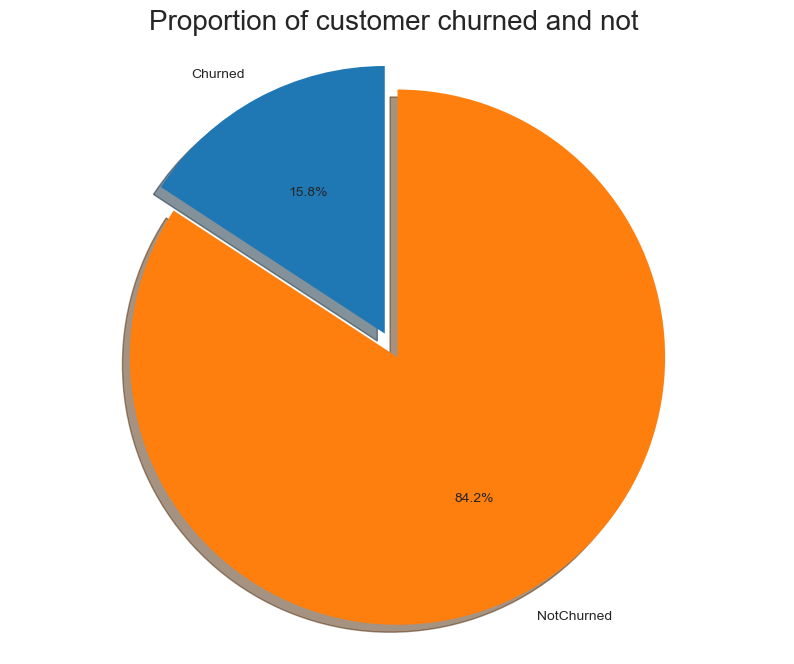

In [427]:
labels = 'Churned', 'NotChurned'
sizes = [df_cust_acc_tran.Churn[df_cust_acc_tran['Churn']=='Yes'].count(), df_cust_acc_tran.Churn[df_cust_acc_tran['Churn']=='No'].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and not ", size = 20)
plt.show()

The dataset is imbalanced as the number of churned is only 15% vs the number not churned is 84%
We will use recall and cross validation scoring

#### Relationship of Churned with categorical variables

<AxesSubplot:xlabel='Investment', ylabel='count'>

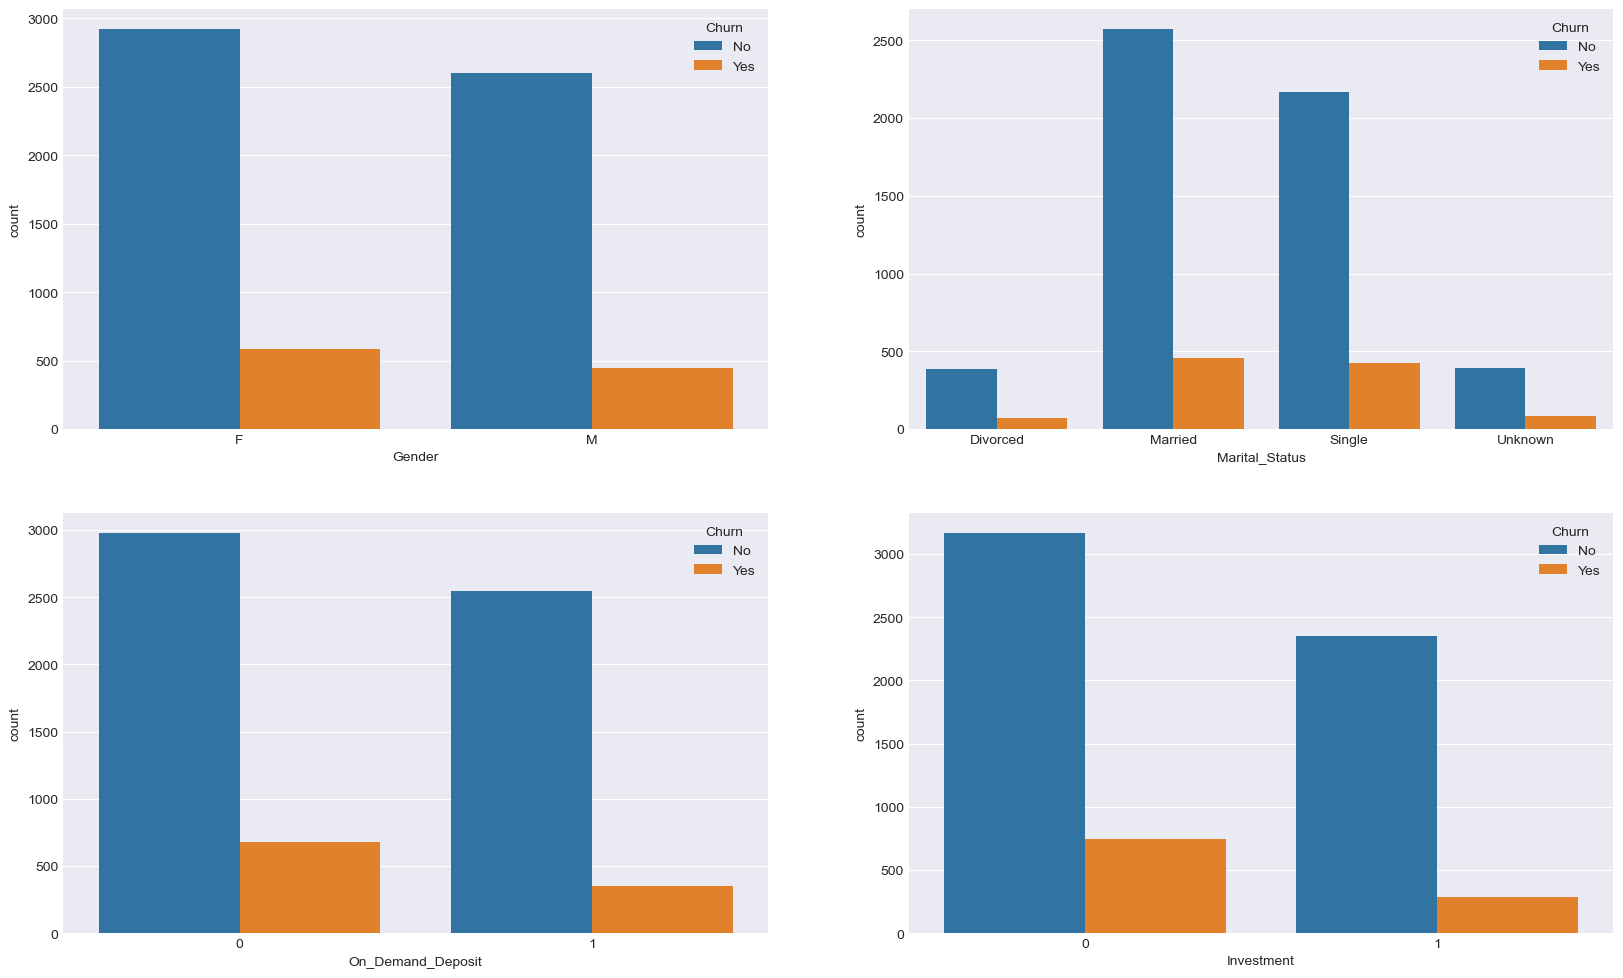

In [428]:

    fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
    sns.countplot(x='Gender', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[0][0])
    sns.countplot(x='Marital_Status', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[0][1])
    sns.countplot(x='On_Demand_Deposit', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[1][0])
    sns.countplot(x='Investment', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[1][1])
   


<AxesSubplot:xlabel='Mortgage', ylabel='count'>

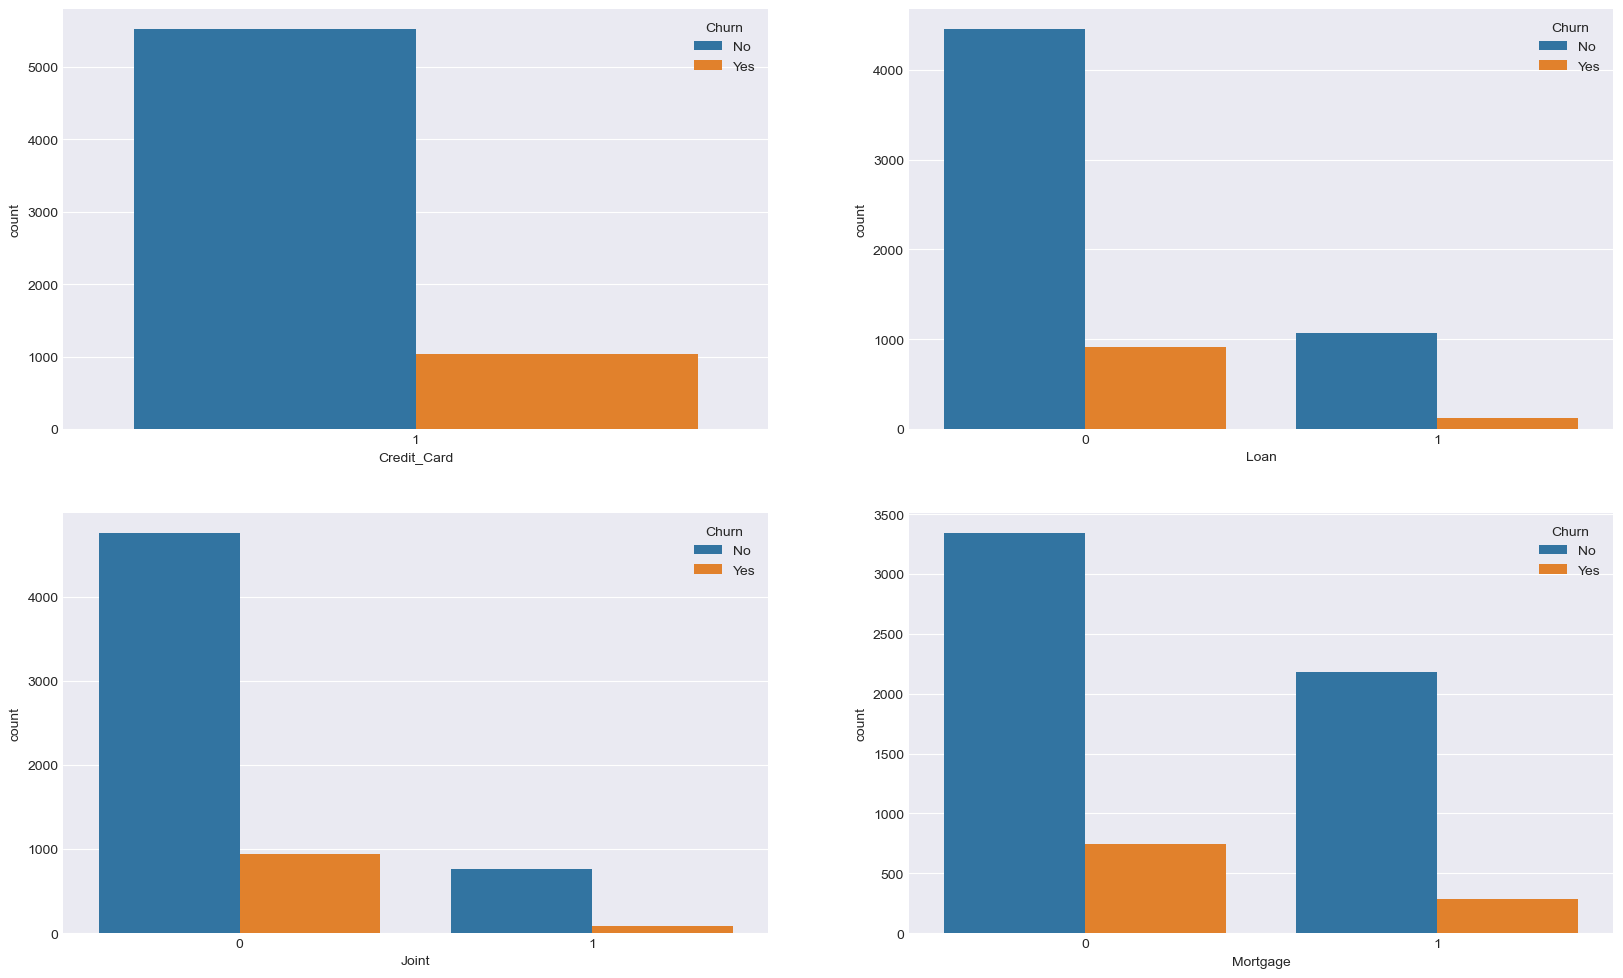

In [429]:
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Credit_Card', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[0][0])
sns.countplot(x='Loan', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[0][1])
sns.countplot(x='Joint', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[1][0])
sns.countplot(x='Mortgage', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[1][1])

<AxesSubplot:xlabel='Income', ylabel='count'>

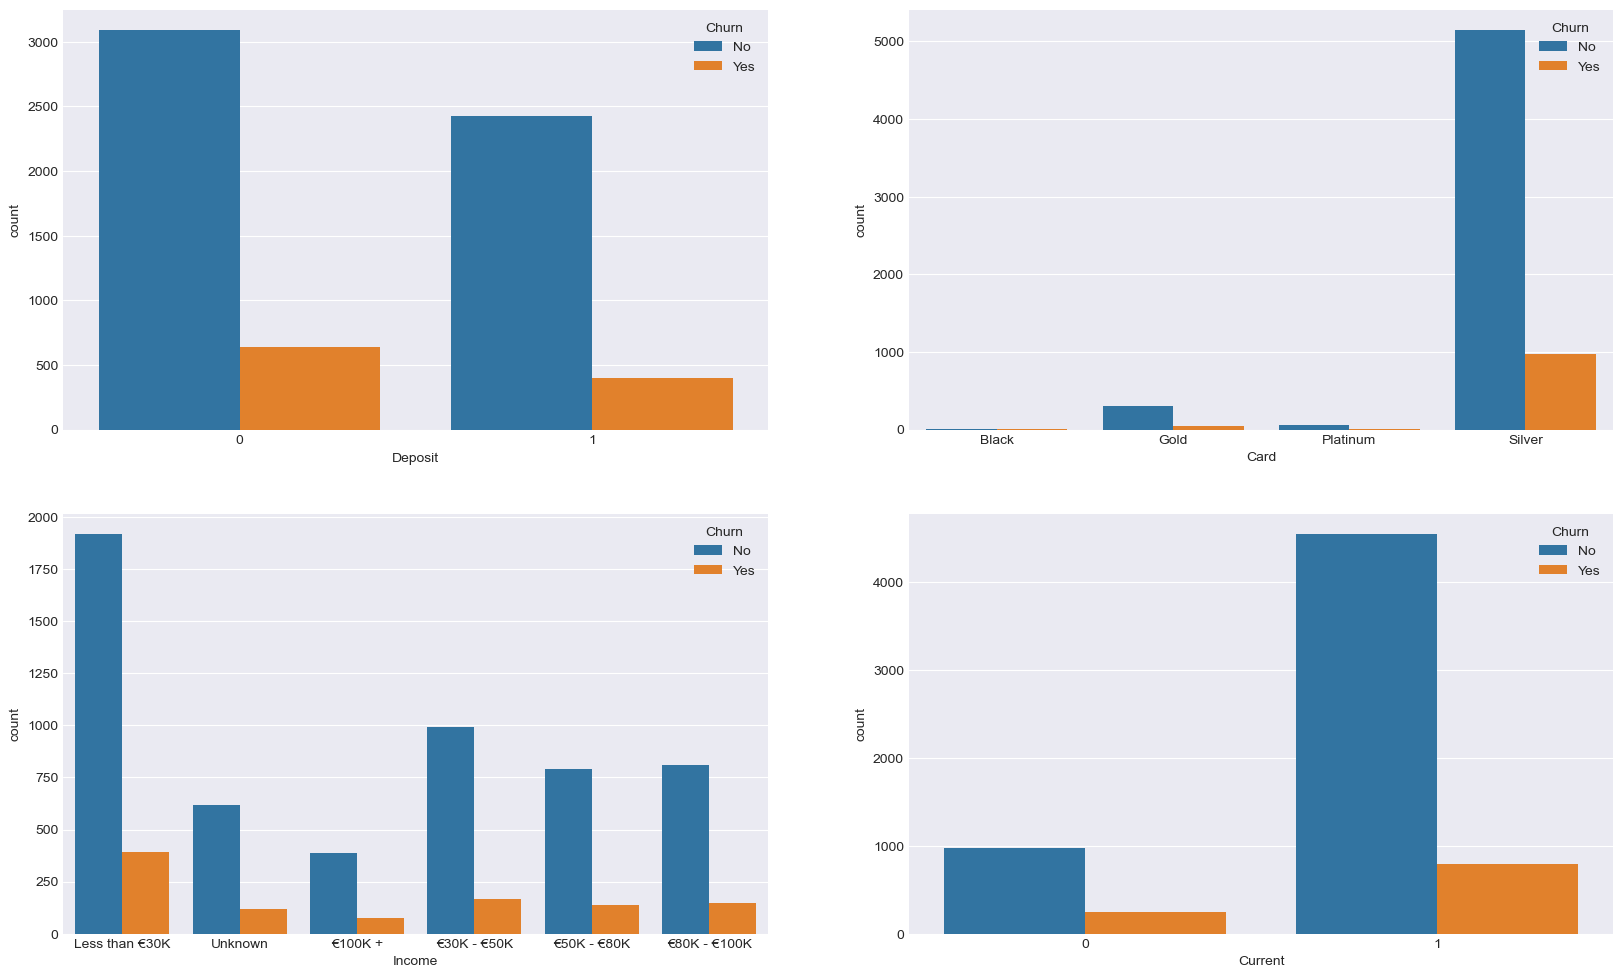

In [430]:
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Current', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[1][1])
sns.countplot(x='Deposit', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[0][0])
sns.countplot(x='Card', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[0][1])
sns.countplot(x='Income', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[1][0])

<AxesSubplot:xlabel='Education', ylabel='count'>

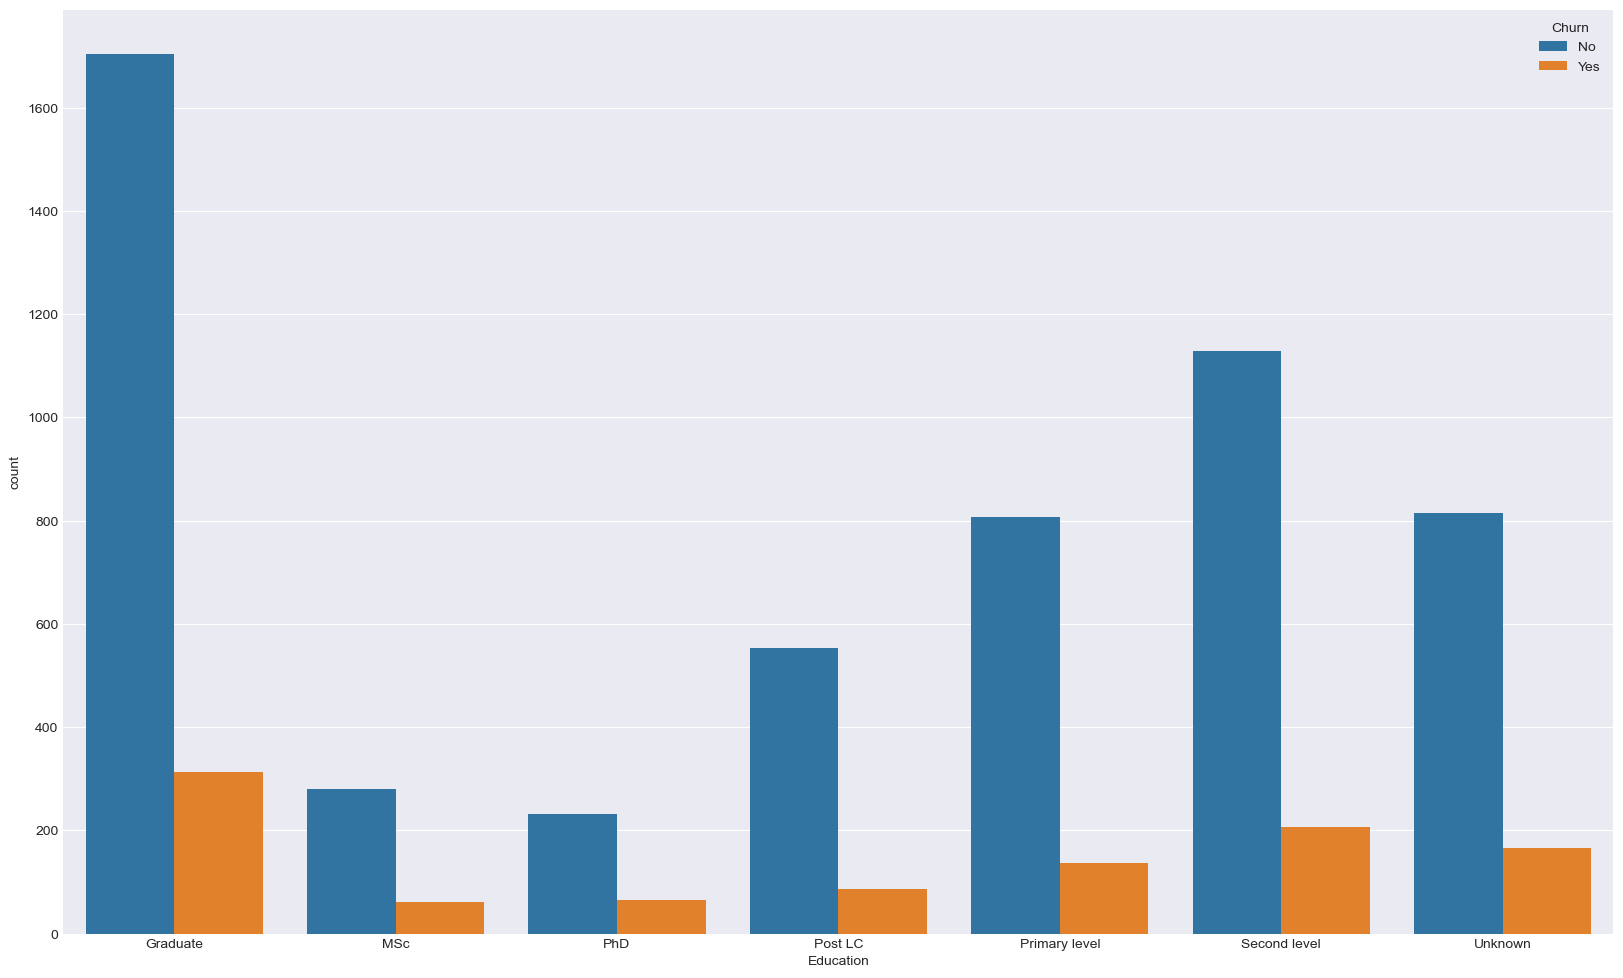

In [431]:
 fig, axarr = plt.subplots(1, 1, figsize=(20, 12))
 sns.countplot(x='Education', hue = 'Churn',data = df_cust_acc_tran, ax=axarr)    

#### Based on categorigcal features, nothing stands out as being significant in terms of a certain feature causing a higher level of churn

#### Relationship based on numerical features

<AxesSubplot:xlabel='Churn', ylabel='Amount'>

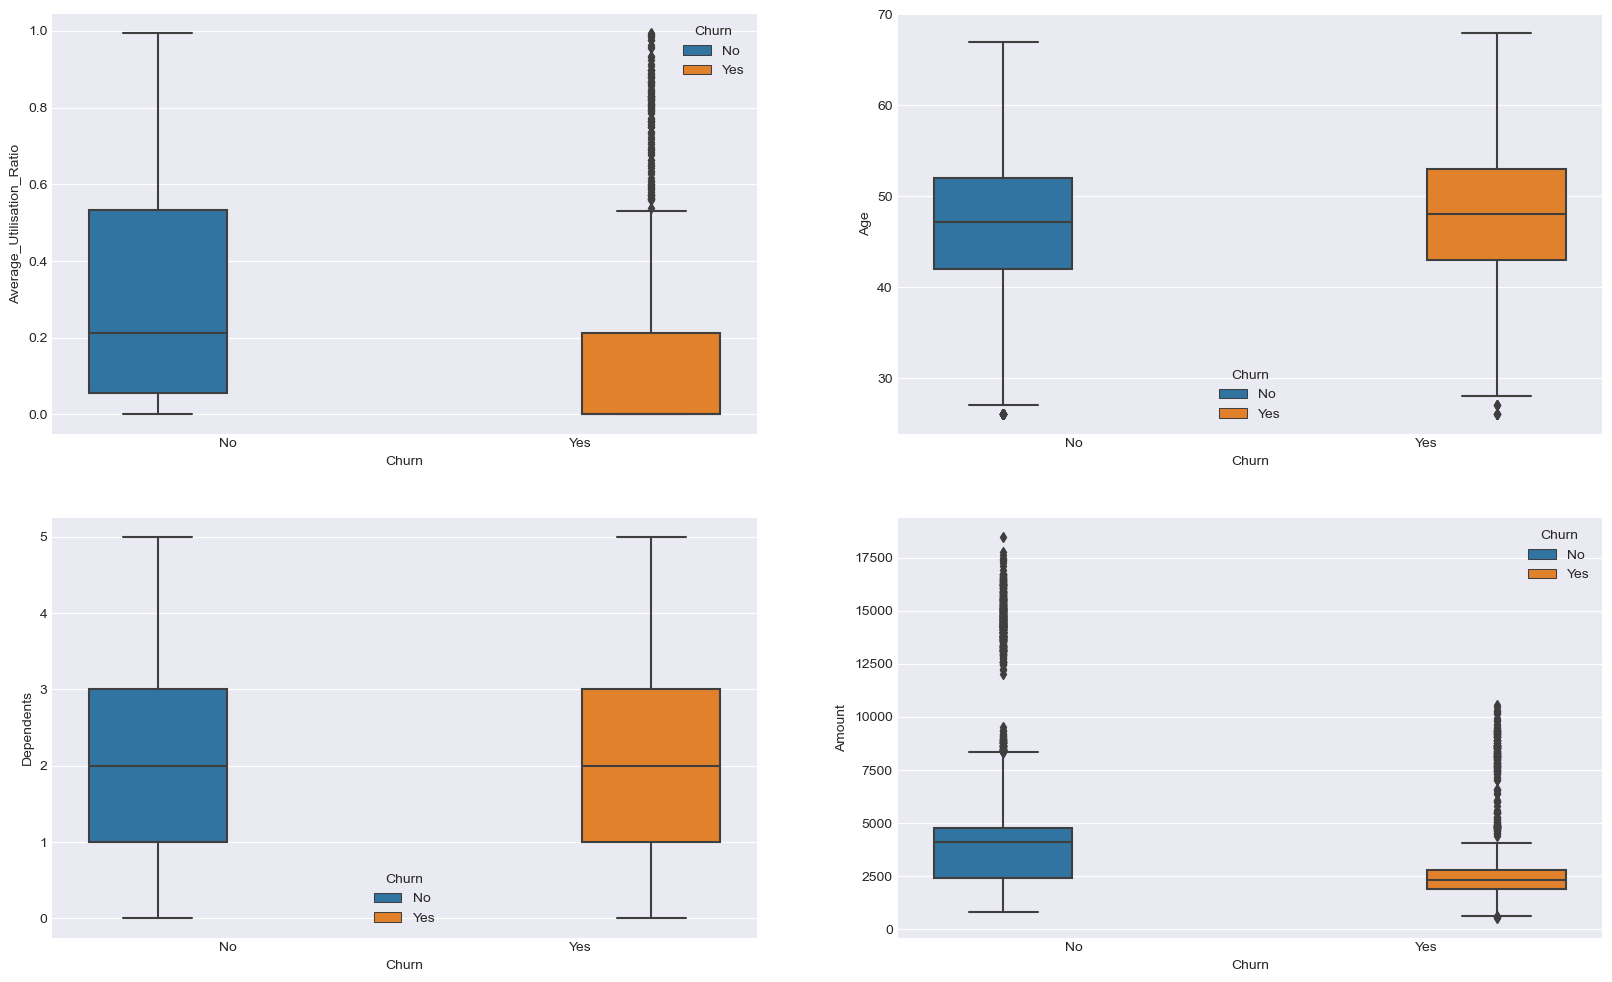

In [432]:

fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.boxplot(y='Average_Utilisation_Ratio',x = 'Churn', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Churn', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[0][1])
sns.boxplot(y='Dependents',x = 'Churn', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[1][0])
sns.boxplot(y='Amount',x = 'Churn', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[1][1])

#### Age or dependante does not look like it will be a significant predictor

<AxesSubplot:xlabel='Churn', ylabel='Average_Open_To_Buy'>

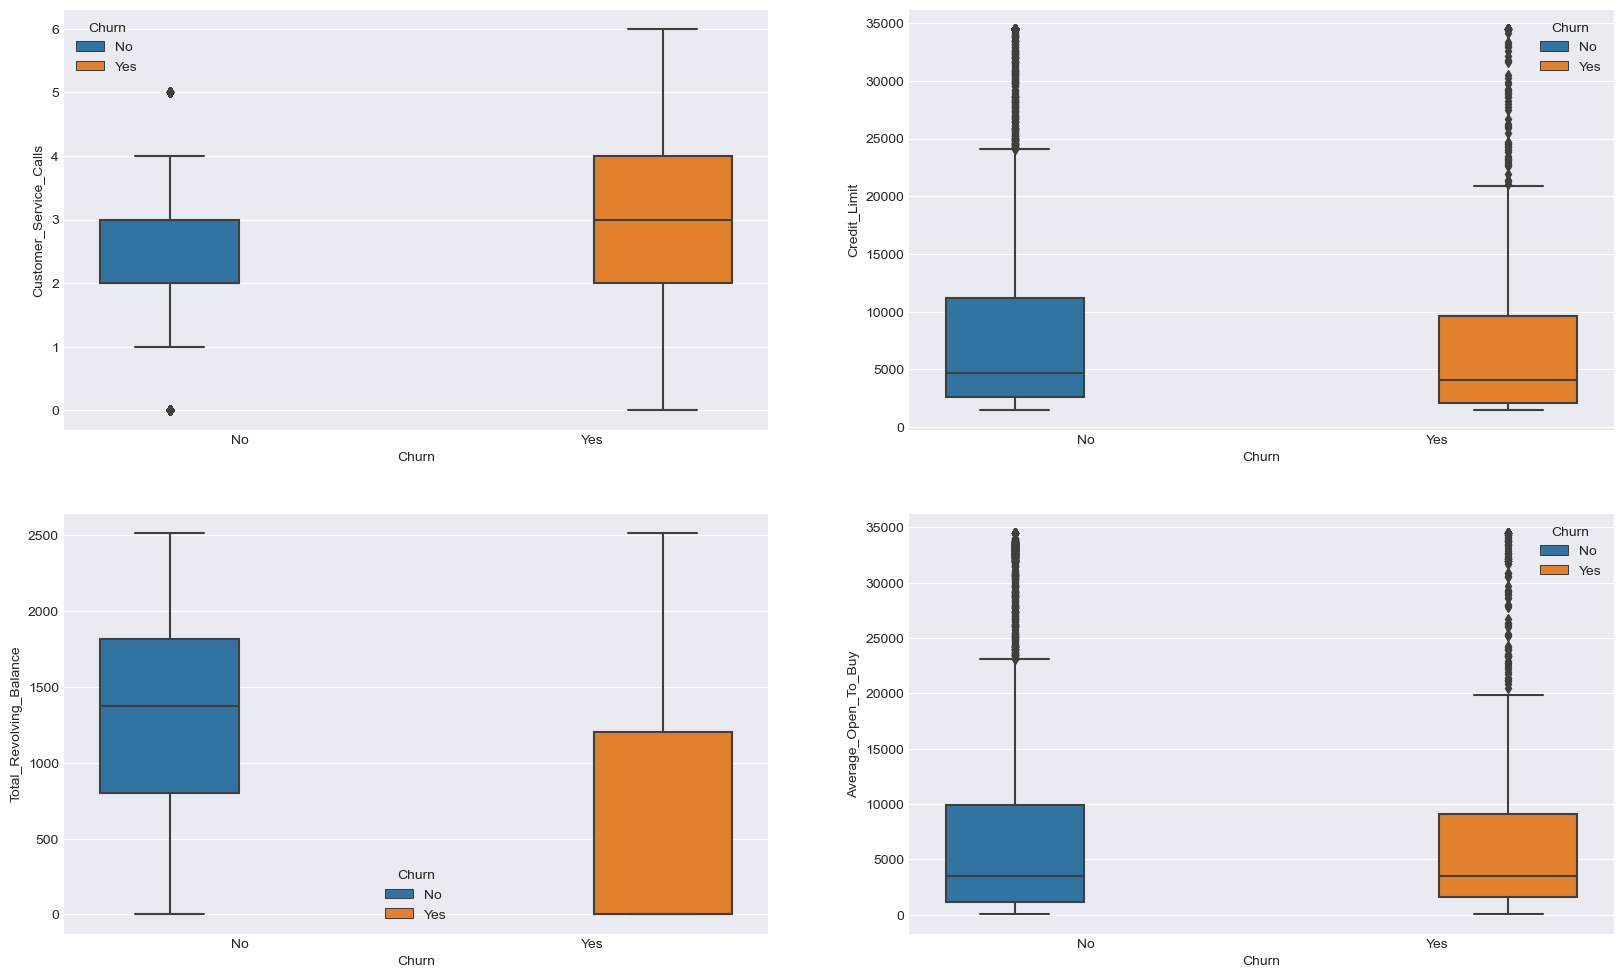

In [433]:
 fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.boxplot(y='Customer_Service_Calls',x = 'Churn', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[0][0])
sns.boxplot(y='Credit_Limit',x = 'Churn', hue = 'Churn',data = df_cust_acc_tran , ax=axarr[0][1])
sns.boxplot(y='Total_Revolving_Balance',x = 'Churn', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[1][0])
sns.boxplot(y='Average_Open_To_Buy',x = 'Churn', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[1][1])

#### Average open to buy and credit limit do no look like they will be big predictors

<AxesSubplot:xlabel='Churn', ylabel='nb_months'>

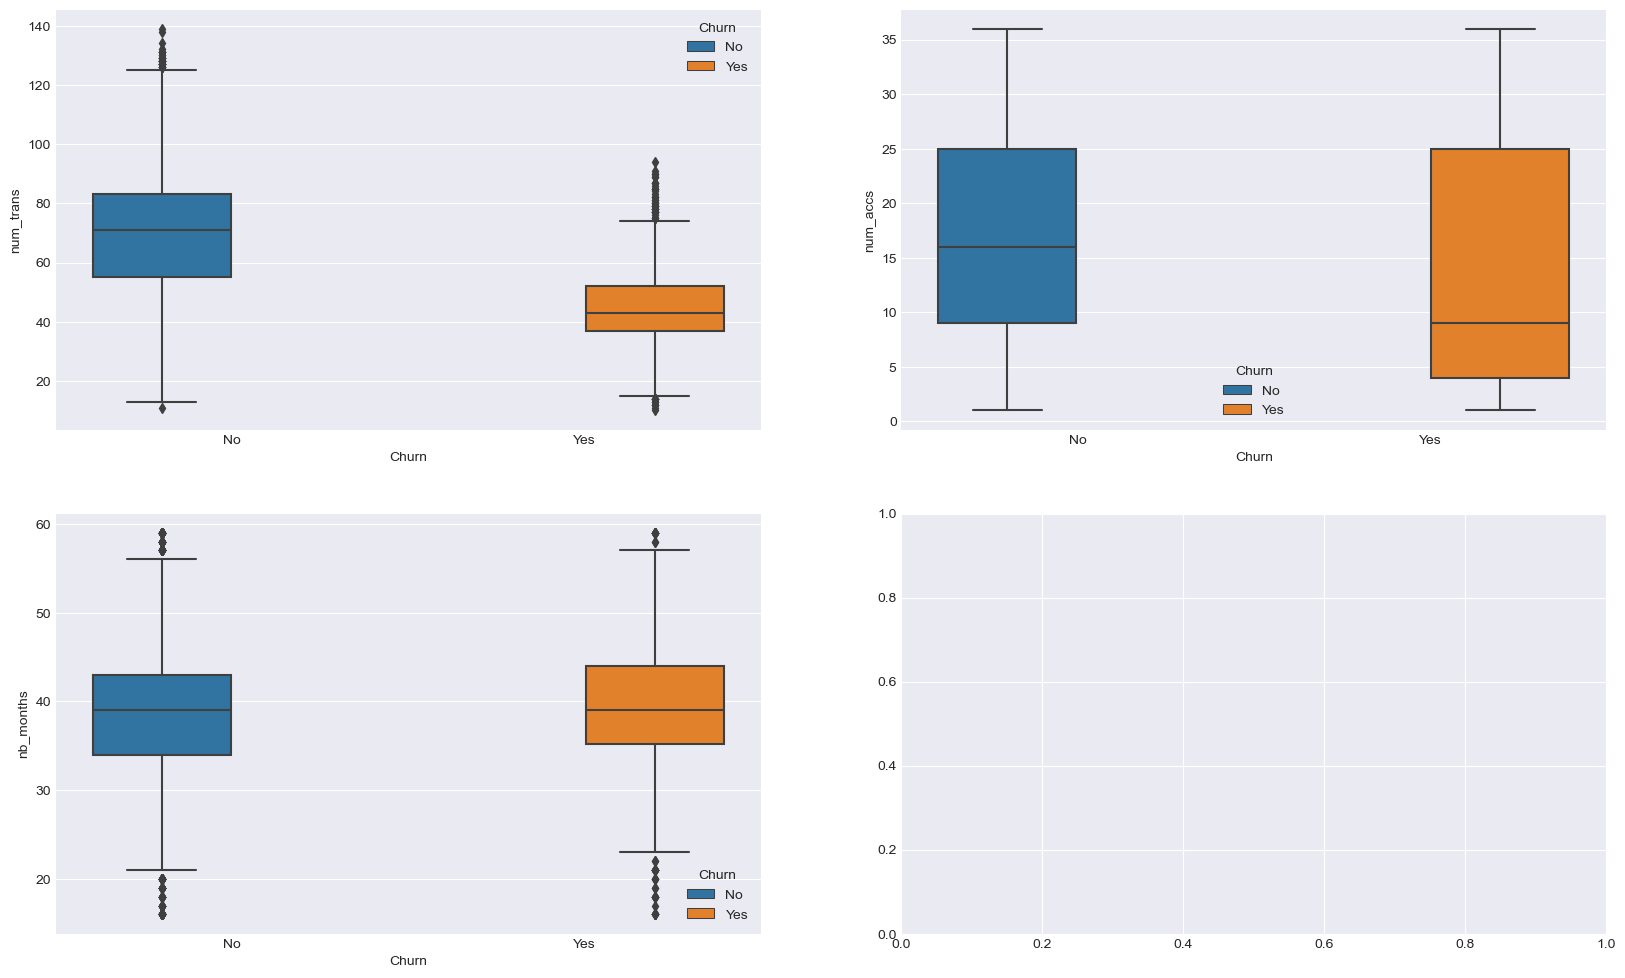

In [434]:
 fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.boxplot(y='num_trans',x = 'Churn', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[0][0])
sns.boxplot(y='num_accs',x = 'Churn', hue = 'Churn',data = df_cust_acc_tran , ax=axarr[0][1])
sns.boxplot(y='nb_months',x = 'Churn', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[1][0])


In [435]:
df_cust_acc_tran['Churn'].loc[df_cust_acc_tran['Churn']=='Yes'] = 1
df_cust_acc_tran['Churn'].loc[df_cust_acc_tran['Churn']=='No'] = 0

In [436]:
df_cust_acc_tran.Churn = pd.Categorical(df_cust_acc_tran.Churn)
df_cust_acc_tran


C:\Users\mccab\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


,Customer,Churn,Card,Start_Date,Customer_Service_Calls,Credit_Limit,Total_Revolving_Balance,Average_Open_To_Buy,Average_Utilisation_Ratio,Age,...,Credit_Card,Current,Deposit,Mortgage,Loan,On_Demand_Deposit,Joint,Investment,num_trans,Amount
0,797197508,0,Silver,2020-06-01,1,2315.0,1565,750.0,0.676,48.000000,...,1,1,1,1,0,0,0,1,90,4827.96
1,812854728,0,Silver,2020-01-01,1,7645.0,2076,5569.0,0.272,58.000000,...,1,0,0,0,0,0,0,0,75,7709.97
2,768000743,0,Silver,2020-01-01,2,6394.0,0,6394.0,0.000,55.000000,...,1,1,0,0,0,0,0,0,69,3470.06
3,722161439,0,Silver,2020-08-01,3,4663.0,0,4663.0,0.000,41.000000,...,1,1,1,1,1,0,0,1,81,3831.01
4,759029725,0,Silver,2021-02-01,4,1879.0,1486,393.0,0.791,37.000000,...,1,1,1,1,0,0,0,1,88,5202.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6551,785444639,0,Silver,2020-01-01,3,3832.0,1439,2393.0,0.376,58.000000,...,1,1,0,0,0,1,0,0,88,4741.00
6552,757416641,0,Silver,2019-08-01,2,4167.0,0,4167.0,0.000,60.000000,...,1,1,0,0,1,1,1,1,85,5039.03
6553,817395226,0,Silver,2019-12-01,2,2470.0,2013,457.0,0.815,42.000000,...,1,1,1,0,0,0,0,1,82,4383.98
6554,732032194,0,Silver,2020-01-01,2,8138.0,2104,6034.0,0.259,47.121602,...,1,1,0,0,0,1,0,1,29,1299.00


In [437]:
#categorical_features = ['Gender', 'Marital_Status', 'On_Demand_Deposit', 'Investment','Loan', 'Joint', 'Mortgage', 'Current', 'Deposit', 'Card','Income', 'Education']
categorical_features = ['Gender', 'Marital_Status', 'Card','Income','Education' ]
#categorical_features = ['Marital_Status', 'Card','Income', 'Credit_Card', 'Mortgage']
numerical_features = ['Customer_Service_Calls','Credit_Limit', 'num_trans', 'num_accs', 'nb_months','Average_Open_To_Buy','Average_Utilisation_Ratio', 'Amount']
#numerical_features = ['Customer_Service_Calls','Total_Revolving_Balance', 'num_trans', 'num_accs' ]


#other_features = ['Start_Date']


features = categorical_features + numerical_features #+ other_features

target = 'Churn'

variables = features + [target]

2nd pass we will still drop missing values for now

In [438]:
df_model = df_cust_acc_tran[variables].dropna()
df_model.shape
df_model

,Gender,Marital_Status,Card,Income,Education,Customer_Service_Calls,Credit_Limit,num_trans,num_accs,nb_months,Average_Open_To_Buy,Average_Utilisation_Ratio,Amount,Churn
0,F,Married,Silver,Less than €30K,Graduate,1,2315.0,90,25,34,750.0,0.676,4827.96,0
1,F,Single,Silver,Less than €30K,Second level,1,7645.0,75,1,39,5569.0,0.272,7709.97,0
2,F,Single,Silver,Less than €30K,Second level,2,6394.0,69,4,39,6394.0,0.000,3470.06,0
3,F,Unknown,Silver,€30K - €50K,Graduate,3,4663.0,81,36,32,4663.0,0.000,3831.01,0
4,F,Single,Silver,Less than €30K,Second level,4,1879.0,88,25,26,393.0,0.791,5202.04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6551,F,Married,Silver,Less than €30K,Unknown,3,3832.0,88,9,39,2393.0,0.376,4741.00,0
6552,F,Married,Silver,Less than €30K,Post LC,2,4167.0,85,36,44,4167.0,0.000,5039.03,0
6553,F,Married,Silver,€30K - €50K,Graduate,2,2470.0,82,16,40,457.0,0.815,4383.98,0
6554,F,Married,Silver,Unknown,Second level,2,8138.0,29,16,39,6034.0,0.259,1299.00,0


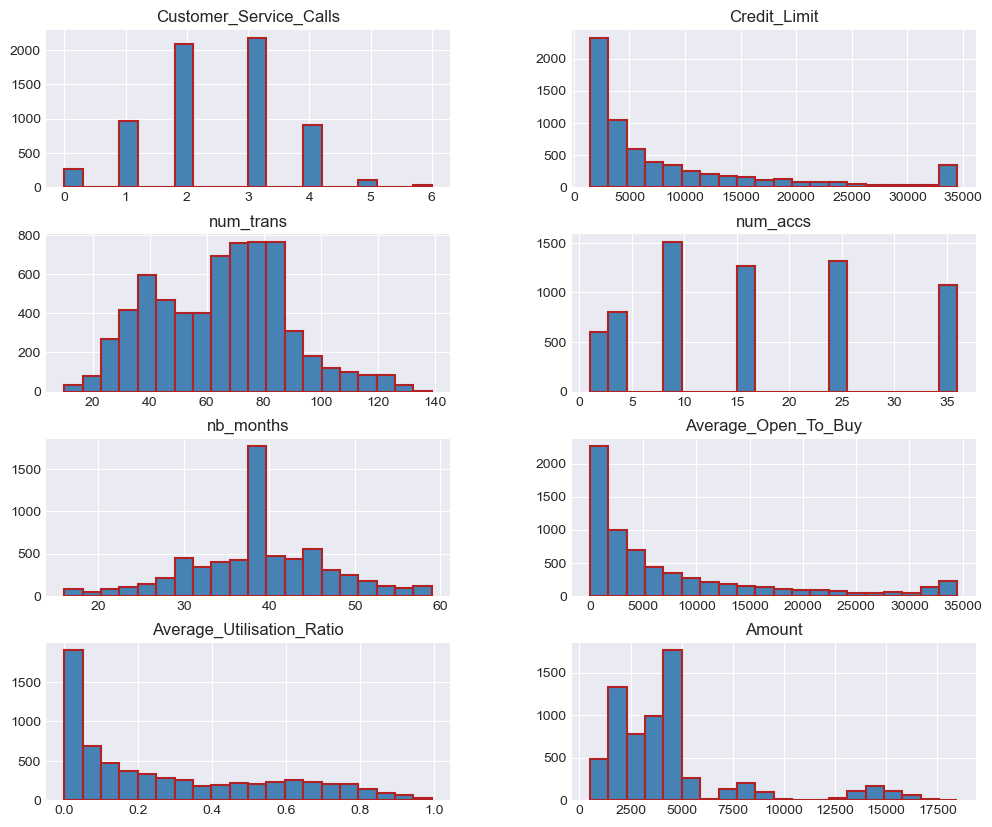

In [439]:
df_model[numerical_features].hist(figsize=(12, 10),
                          bins=20,
                          layout=(4, 2),
                          color='steelblue',
                          edgecolor='firebrick',
                          linewidth=1.5);

In [440]:
from sklearn.preprocessing import  StandardScaler

In [441]:
scaler = StandardScaler()

In [442]:


df_model[numerical_features] = scaler.fit_transform(df_model[numerical_features])

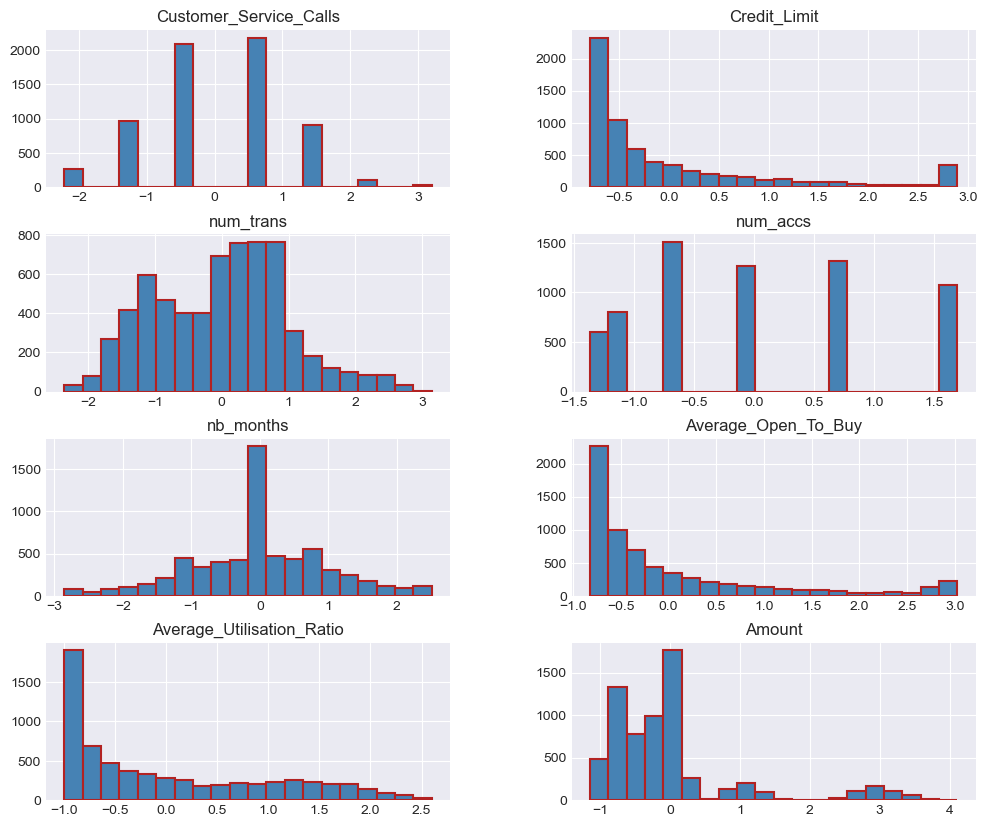

In [443]:
df_model[numerical_features].hist(figsize=(12, 10),
                          bins=20,
                          layout=(4, 2),
                          color='steelblue',
                          edgecolor='firebrick',
                          linewidth=1.5);

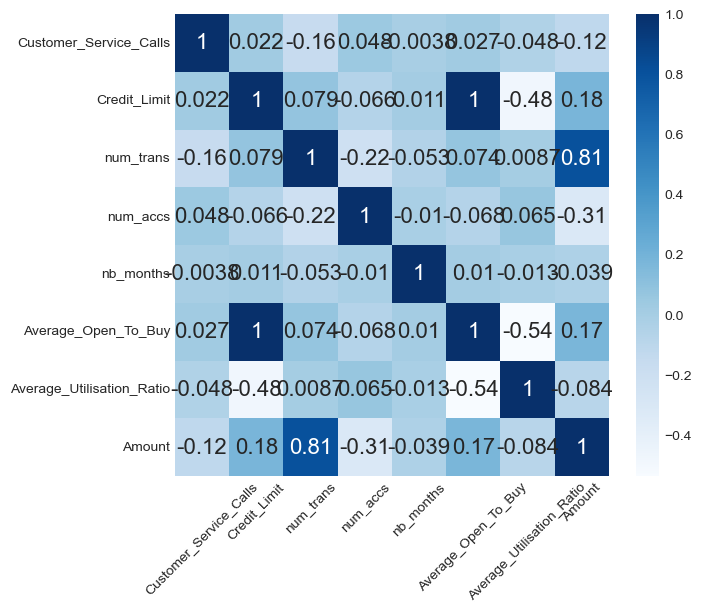

In [444]:
fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(df_model[numerical_features].corr(),
            annot=True,
            annot_kws={'fontsize': 16},
            cmap='Blues',
            ax=ax)

ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=360);

#### There is multicollinearity between some of the features
#### Amount and num_trans
#### Average utilisation ratio and total revolving balance


In [445]:
df_model.to_pickle('output/df_model.pkl')

In [446]:
columns = df_model.columns[10:]
columns

Index(['Average_Open_To_Buy', 'Average_Utilisation_Ratio', 'Amount', 'Churn'], dtype='object')

In [447]:
columns = df_model.columns[10:]
corr = df_model[columns].corr()
corr

,Average_Open_To_Buy,Average_Utilisation_Ratio,Amount
Average_Open_To_Buy,1.000000,-0.537354,0.172028
Average_Utilisation_Ratio,-0.537354,1.000000,-0.083581
Amount,0.172028,-0.083581,1.000000


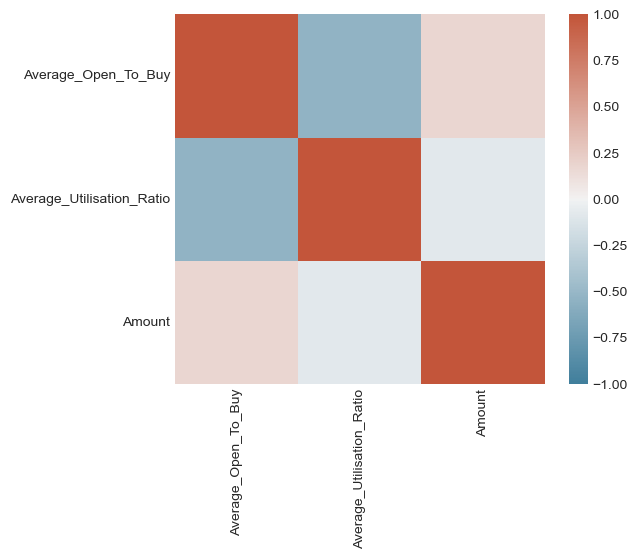

In [448]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, square=True, vmin=-1, vmax=1, cmap=cmap);

### Train / Test Split

In [449]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_model[features], df_model.Churn, 
    train_size=0.7, random_state=SEED, stratify=df_model.Churn)

In [450]:
X_train

,Gender,Marital_Status,Card,Income,Education,Customer_Service_Calls,Credit_Limit,num_trans,num_accs,nb_months,Average_Open_To_Buy,Average_Utilisation_Ratio,Amount
3236,M,Married,Silver,Less than €30K,Primary level,0.493507,-0.604625,-1.459128,-0.056392,0.015892,-0.545060,-0.269853,-0.864640
4546,F,Married,Silver,€30K - €50K,Unknown,-1.311979,-0.709326,0.841006,1.692449,1.263672,-0.707495,0.894347,0.093894
59,M,Unknown,Silver,€80K - €100K,Post LC,0.493507,-0.430346,-0.394251,-0.668486,0.265448,-0.300516,-0.996575,-0.186677
2696,M,Single,Silver,€30K - €50K,Second level,-1.311979,-0.704866,0.628030,-1.105696,-0.732775,-0.704929,0.887116,-0.073332
4816,M,Married,Silver,€100K +,Unknown,0.493507,2.894900,-1.033178,-1.368023,-0.233664,2.745695,-0.732641,-0.698299
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5706,F,Divorced,Silver,Less than €30K,Graduate,-0.409236,-0.793366,-1.544318,0.730587,-1.107109,-0.739480,0.709955,-0.971839
3575,M,Unknown,Silver,€80K - €100K,Graduate,-0.409236,1.424062,0.159485,-1.105696,0.639782,1.309775,-0.624175,0.766580
4066,F,Married,Silver,Less than €30K,Primary level,0.493507,-0.793366,0.883601,-0.668486,0.265448,-0.663729,-0.996575,0.046439
797,F,Single,Silver,€30K - €50K,Second level,1.396250,-0.793366,-0.990582,-0.668486,0.015892,-0.663729,-0.996575,-0.686291


In [451]:
y_train

3236    0
4546    0
59      0
2696    0
4816    0
       ..
5706    0
3575    0
4066    0
797     1
10      0
Name: Churn, Length: 4589, dtype: category
Categories (2, int64): [0, 1]

### Import Classifiers

In [452]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier

In [453]:
import joblib

### Build a Pipeline

In [454]:
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
column_transformer = ColumnTransformer([
    # List of transformation to apply and which columns to apply it to. Each entry here has structure 
    #( NAME,                  CODE,                           COLUMNS_TO_APPLY),
    ( 'categorical_features', preprocessing.OneHotEncoder(),  categorical_features ),
    ( 'numerical_features',   preprocessing.StandardScaler(), numerical_features ),
])

In [455]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ( 'column_transformer', column_transformer ),
    ( 'classifier', LogisticRegression(solver='lbfgs', max_iter=200) ),
])

In [456]:
from sklearn.metrics import recall_score
pipeline.fit(X_train, y_train)
y_true = y_test
y_pred = pipeline.predict(X_test)
recall_score(y_true, y_pred, average='macro')

0.6972122179609477

### Score the model using cross validation scoring function to see how good the initial one is

In [298]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print(f"CV estimate of accuracy is {scores.mean():.2%} +/ {2*scores.std()/len(scores):.2%}")

CV estimate of accuracy is 88.54% +/ 0.34%


In [320]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('categorical_features',
                                                  OneHotEncoder(),
                                                  ['Marital_Status', 'Card',
                                                   'Income', 'Credit_Card',
                                                   'Mortgage']),
                                                 ('numerical_features',
                                                  StandardScaler(),
                                                  ['Customer_Service_Calls',
                                                   'Total_Revolving_Balance',
                                                   'num_trans',
                                                   'num_accs'])])),
                ('classifier', LogisticRegression(max_iter=200))])

In [321]:
filename = "Completed_model_LogReg.joblib"

In [322]:
joblib.dump(pipeline, filename)

['Completed_model_LogReg.joblib']

### CV estimate of accuracy is 87.26% +/ 0.25%

In [379]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ( 'column_transformer', column_transformer ),
    ( 'classifier', AdaBoostClassifier() ),
])

In [380]:
from sklearn.metrics import recall_score
pipeline.fit(X_train, y_train)
y_true = y_test
y_pred = pipeline.predict(X_test)
recall_score(y_true, y_pred, average='macro')

0.8625294449743999

In [227]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X_train, y_train, cv=10)
print(f"CV estimate of accuracy is {scores.mean():.2%} +/ {2*scores.std()/len(scores):.2%}")

CV estimate of accuracy is 93.51% +/ 0.20%


In [242]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('categorical_features',
                                                  OneHotEncoder(),
                                                  ['Gender', 'Marital_Status',
                                                   'Card', 'Income',
                                                   'Credit_Card', 'Mortgage']),
                                                 ('numerical_features',
                                                  StandardScaler(),
                                                  ['Customer_Service_Calls',
                                                   'Total_Revolving_Balance',
                                                   'num_trans', 'num_accs',
                                                   'nb_months'])])),
                ('classifier', AdaBoostClassifier())])

## CV estimate of accuracy is 91.03% +/ 0.63%


In [243]:
filename = "Completed_model_ADABoost.joblib"

In [244]:
joblib.dump(pipeline, filename)

['Completed_model_ADABoost.joblib']

In [458]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ( 'column_transformer', column_transformer ),
    ( 'classifier', GradientBoostingClassifier(learning_rate= 0.25, n_estimators= 200, max_depth= 4.0, min_samples_split= 0.4, min_samples_leaf= 0.1) ),
])

In [460]:
from sklearn.metrics import recall_score
pipeline.fit(X_train, y_train)
y_true = y_test
y_pred = pipeline.predict(X_test)
recall_score(y_true, y_pred, average='weighted')

0.9354346720894764

In [461]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print(f"CV estimate of accuracy is {scores.mean():.2%} +/ {2*scores.std()/len(scores):.2%}")

CV estimate of accuracy is 93.66% +/ 0.05%


In [462]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('categorical_features',
                                                  OneHotEncoder(),
                                                  ['Gender', 'Marital_Status',
                                                   'Card', 'Income',
                                                   'Education']),
                                                 ('numerical_features',
                                                  StandardScaler(),
                                                  ['Customer_Service_Calls',
                                                   'Credit_Limit', 'num_trans',
                                                   'num_accs', 'nb_months',
                                                   'Average_Open_To_Buy',
                                                   'Average_Utilisation_Ratio',
                                                   'Amount'])])),
             

## CV estimate of accuracy is 91.03% +/ 0.63%


In [463]:
filename = "Completed_model_GradBoost.joblib"

In [464]:
joblib.dump(pipeline, filename)

['Completed_model_GradBoost.joblib']

In [365]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ( 'column_transformer', column_transformer ),
    ( 'classifier', GaussianNB() ),
])

In [231]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print(f"CV estimate of accuracy is {scores.mean():.2%} +/ {2*scores.std()/len(scores):.2%}")

CV estimate of accuracy is 83.77% +/ 0.62%


In [366]:
from sklearn.metrics import recall_score
pipeline.fit(X_train, y_train)
y_true = y_test
y_pred = pipeline.predict(X_test)
recall_score(y_true, y_pred, average='macro')

0.7092637296318648

In [252]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('categorical_features',
                                                  OneHotEncoder(),
                                                  ['Gender', 'Marital_Status',
                                                   'Card', 'Income',
                                                   'Credit_Card', 'Mortgage']),
                                                 ('numerical_features',
                                                  StandardScaler(),
                                                  ['Customer_Service_Calls',
                                                   'Total_Revolving_Balance',
                                                   'num_trans', 'num_accs',
                                                   'nb_months'])])),
                ('classifier', GaussianNB())])

## CV estimate of accuracy is 91.03% +/ 0.63%


In [253]:
filename = "Completed_model_GaussianNB.joblib"

In [254]:
joblib.dump(pipeline, filename)

['Completed_model_GaussianNB.joblib']

In [3]:
y_train['Churn'].loc[y_train['Churn']=='Yes'] =1
y_train['Churn'].loc[y_train['Churn']=='No'] = 0

NameError: name 'y_train' is not defined

In [367]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ( 'column_transformer', column_transformer ),
    ( 'classifier', XGBClassifier() ),
])

In [368]:
from sklearn.metrics import recall_score
pipeline.fit(X_train, y_train)
y_true = y_test
y_pred = pipeline.predict(X_test)
recall_score(y_true, y_pred, average='macro')

0.8821860338349523

In [233]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print(f"CV estimate of accuracy is {scores.mean():.2%} +/ {2*scores.std()/len(scores):.2%}")

CV estimate of accuracy is 94.60% +/ 0.14%


In [257]:
pipeline.fit(X_train, y_train)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['No' 'Yes']

In [1]:
filename = "Completed_model_XGBClassifier.joblib"

In [2]:
joblib.dump(pipeline, filename)

NameError: name 'joblib' is not defined

In [369]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ( 'column_transformer', column_transformer ),
    ( 'classifier', SVC() ),
])

In [370]:
from sklearn.metrics import recall_score
pipeline.fit(X_train, y_train)
y_true = y_test
y_pred = pipeline.predict(X_test)
recall_score(y_true, y_pred, average='macro')

0.7552660268265619

In [235]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print(f"CV estimate of accuracy is {scores.mean():.2%} +/ {2*scores.std()/len(scores):.2%}")

CV estimate of accuracy is 91.26% +/ 0.16%


In [262]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('categorical_features',
                                                  OneHotEncoder(),
                                                  ['Gender', 'Marital_Status',
                                                   'Card', 'Income',
                                                   'Credit_Card', 'Mortgage']),
                                                 ('numerical_features',
                                                  StandardScaler(),
                                                  ['Customer_Service_Calls',
                                                   'Total_Revolving_Balance',
                                                   'num_trans', 'num_accs',
                                                   'nb_months'])])),
                ('classifier', SVC())])

## CV estimate of accuracy is 91.03% +/ 0.63%


In [263]:
filename = "Completed_model_ColTrans.joblib"

In [264]:
joblib.dump(pipeline, filename)

['Completed_model_ColTrans.joblib']

In [371]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ( 'column_transformer', column_transformer ),
    ( 'classifier', RandomForestClassifier() ),
])

In [372]:
from sklearn.metrics import recall_score
pipeline.fit(X_train, y_train)
y_true = y_test
y_pred = pipeline.predict(X_test)
recall_score(y_true, y_pred, average='macro')

0.8147351412385384

In [347]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print(f"CV estimate of accuracy is {scores.mean():.2%} +/ {2*scores.std()/len(scores):.2%}")


CV estimate of accuracy is 94.90% +/ 0.27%


Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('categorical_features',
                                                  OneHotEncoder(),
                                                  ['Gender', 'Marital_Status',
                                                   'Card', 'Income',
                                                   'Education']),
                                                 ('numerical_features',
                                                  StandardScaler(),
                                                  ['Customer_Service_Calls',
                                                   'Credit_Limit', 'num_trans',
                                                   'num_accs', 'nb_months',
                                                   'Average_Open_To_Buy',
                                                   'Average_Utilisation_Ratio',
                                                   'Amount'])])),
             

In [267]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('categorical_features',
                                                  OneHotEncoder(),
                                                  ['Gender', 'Marital_Status',
                                                   'Card', 'Income',
                                                   'Credit_Card', 'Mortgage']),
                                                 ('numerical_features',
                                                  StandardScaler(),
                                                  ['Customer_Service_Calls',
                                                   'Total_Revolving_Balance',
                                                   'num_trans', 'num_accs',
                                                   'nb_months'])])),
                ('classifier', RandomForestClassifier())])

In [268]:
filename = "Completed_model_RandForest.joblib"

In [269]:
import joblib

In [270]:
joblib.dump(pipeline, filename)

['Completed_model_RandForest.joblib']

In [271]:
y_pred = pipeline.predict(X_test)

In [272]:
y_pred

array(['Yes', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [339]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import optuna

def objective(trial):
    params = {
        "metric": "rmse",
        "n_estimators": 6000,
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 6000),
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    predictions = model.predict(X_train)
    rmse = mean_squared_error(y_train, predictions, squared=False)
    return rmse

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

In [363]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ( 'column_transformer', column_transformer ),
    ( 'classifier', LGBMClassifier()),
])

In [350]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print(f"CV estimate of accuracy is {scores.mean():.2%} +/ {2*scores.std()/len(scores):.2%}")

CV estimate of accuracy is 94.90% +/ 0.27%


In [364]:
from sklearn.metrics import recall_score
pipeline.fit(X_train, y_train)
y_true = y_test
y_pred = pipeline.predict(X_test)
recall_score(y_true, y_pred, average='macro')


0.8795637276850896

In [319]:
pipeline.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('categorical_features',
                                                  OneHotEncoder(),
                                                  ['Gender', 'Marital_Status',
                                                   'Card', 'Income',
                                                   'Education']),
                                                 ('numerical_features',
                                                  StandardScaler(),
                                                  ['Customer_Service_Calls',
                                                   'Credit_Limit', 'num_trans',
                                                   'num_accs', 'nb_months',
                                                   'Average_Open_To_Buy',
                                                   'Average_Utilisation_Ratio',
                                                   'Amount'])])),
             

In [320]:
filename = "Completed_model_LGBM.joblib"

In [321]:
joblib.dump(pipeline, filename)

['Completed_model_LGBM.joblib']

In [278]:
###############################################################

In [373]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ( 'column_transformer', column_transformer ),
    ( 'classifier', BernoulliNB() ),
])

In [374]:
from sklearn.metrics import recall_score
pipeline.fit(X_train, y_train)
y_true = y_test
y_pred = pipeline.predict(X_test)
recall_score(y_true, y_pred, average='macro')

0.6430918683201277

In [241]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print(f"CV estimate of accuracy is {scores.mean():.2%} +/ {2*scores.std()/len(scores):.2%}")

CV estimate of accuracy is 85.73% +/ 0.47%


In [281]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('categorical_features',
                                                  OneHotEncoder(),
                                                  ['Gender', 'Marital_Status',
                                                   'Card', 'Income',
                                                   'Credit_Card', 'Mortgage']),
                                                 ('numerical_features',
                                                  StandardScaler(),
                                                  ['Customer_Service_Calls',
                                                   'Total_Revolving_Balance',
                                                   'num_trans', 'num_accs',
                                                   'nb_months'])])),
                ('classifier', BernoulliNB())])

## CV estimate of accuracy is 91.03% +/ 0.63%


In [282]:
filename = "Completed_model_BernNB.joblib"

In [283]:
joblib.dump(pipeline, filename)

['Completed_model_BernNB.joblib']

## CV estimate of accuracy is 83.07% +/ 0.23%

In [375]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ( 'column_transformer', column_transformer ),
    ( 'classifier', KNeighborsClassifier(n_neighbors=13) ),
])

In [376]:
from sklearn.metrics import recall_score
pipeline.fit(X_train, y_train)
y_true = y_test
y_pred = pipeline.predict(X_test)
recall_score(y_true, y_pred, average='macro')

C:\Users\mccab\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.6428621488504292

In [243]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X_train, y_train, cv=15)
print(f"CV estimate of accuracy is {scores.mean():.2%} +/ {2*scores.std()/len(scores):.2%}")

C:\Users\mccab\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\mccab\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

CV estimate of accuracy is 88.34% +/ 0.14%


C:\Users\mccab\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\mccab\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [286]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('categorical_features',
                                                  OneHotEncoder(),
                                                  ['Gender', 'Marital_Status',
                                                   'Card', 'Income',
                                                   'Credit_Card', 'Mortgage']),
                                                 ('numerical_features',
                                                  StandardScaler(),
                                                  ['Customer_Service_Calls',
                                                   'Total_Revolving_Balance',
                                                   'num_trans', 'num_accs',
                                                   'nb_months'])])),
                ('classifier', KNeighborsClassifier(n_neighbors=9))])

## CV estimate of accuracy is 91.03% +/ 0.63%


In [287]:
filename = "Completed_model_KNear.joblib"

In [288]:
joblib.dump(pipeline, filename)

['Completed_model_KNear.joblib']

In [294]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    { 
        'classifier__n_neighbors': range(3,17,2),
    }
]

gs = GridSearchCV(pipeline, param_grid=param_grid, scoring='accuracy', cv=15, n_jobs=-1)

### CV estimate of accuracy is 86.24% +/ 0.27%

In [295]:
gs.fit(X_train, y_train);

In [296]:
gs.best_params_

{'classifier__n_neighbors': 13}